 This file contains an example for the OMR_extracter software. 
---
This software is supposed to read scanned images of traffic survey forms and extract the recorded data into spreadsheets. The results will be used for data analysis in transportation studies.




##### Please see the video below for the presentation of this project.

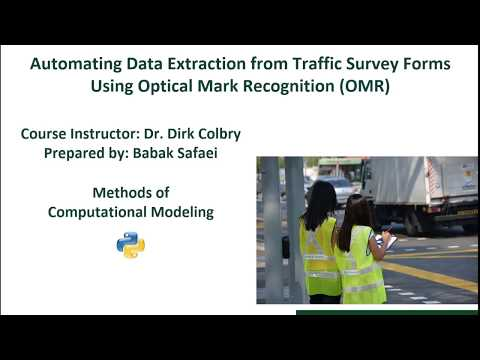

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("WG4IboEoP6U",width=640,height=360)

First, the required packages are imported.

In [2]:
from omr_extracter import omr_extract
import pandas as pd
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
sns.set() 

C:\Users\landa\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The required constants are also defined

In [3]:
# mapping rows of sections and answers in form
MAP = {'vehicle_observable': range(0, 1), 'vehicle_use': range(2, 4),
       'vehicle_type': range(5, 9),
       'driver_phoneuse': range(10, 14), 'driver_seatbelt': range(15, 17),
       'driver_age': range(18, 21),
       'driver_gender': range(22, 24), 'driver_race': range(25, 28),
       'passenger_present': range(28, 29), 'passenger_seatbelt': range(30, 32), 'passenger_age': range(33, 37),
       'passenger_gender': range(38, 40), 'passenger_race': range(41, 44)}

NUM_RW, NUM_CL = 44, 10  # number of rows and columns in the survey form
UP = 0  # top margin info of the survey form for cutting
DOWN = 0  # down margin info of the survey form for cutting
RIGHT = 70  # right margin info of the survey form for cutting
LEFT = 70  # left margin info of the survey form for cutting
TOPX, TOPY = 369, 67  # starting point of grids in top and left of survey form
STEPX, STEPY = 200, 65  # step size for answer boxes

In the following cell, a sample image from the filled form is loaded and shown for a better understanding of the project.

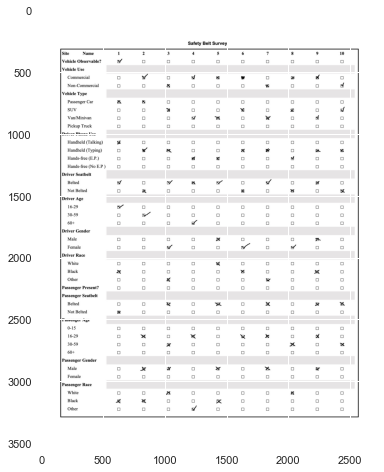

In [4]:
plt.figure(figsize=(13,8))
example_form= omr_extract.show_img('images/one/Scantest.jpg')

In the following cell, the available image in the `./images/three` folder are read and stored in a list named `files`.

In [5]:
files = omr_extract.get_files('images/one')
print(files)

['images/one\\Scantest.jpg', 'images/one\\Scantest2.jpg']


The available images in the `files` list are read in grayscale mode and stored in an array. You may see the array below.

In [6]:
images = omr_extract.imgs_load(files)
images

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

The first image is shown below.

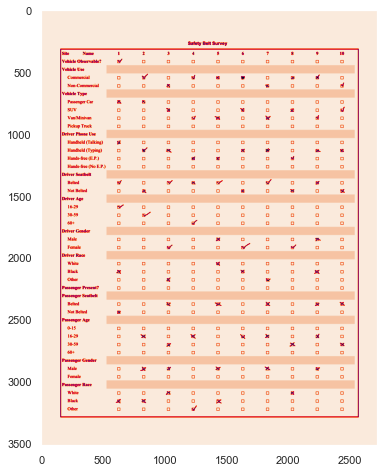

In [7]:
plt.figure(figsize=(13,8))
omr_extract.draw_img(images[0])
plt.grid()

In [8]:
images[0].shape

(3520, 2720)

The image is cropped to include the required part and is represented below.

In [9]:
cropped_image = images[0][UP:images[0].shape[0] -
                          DOWN, LEFT:images[0].shape[1] - RIGHT]

In [10]:
cropped_image.shape

(3520, 2580)

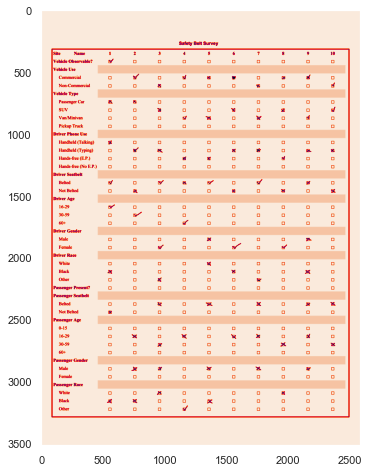

In [11]:
plt.figure(figsize=(13,8))
omr_extract.draw_img(cropped_image)
plt.grid()

Now, the image will be cropped and preprocessed using guassianbluring, canny edge detection and contrast improvement.

In [12]:
pre_processed_image = omr_extract.pre_process(cropped_image)

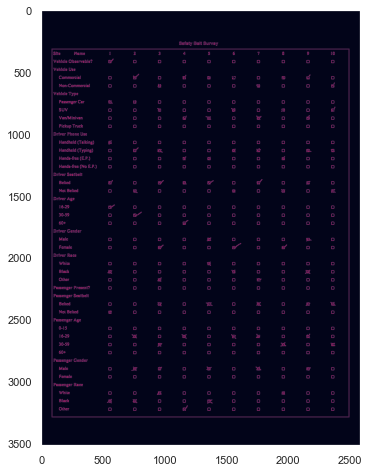

In [13]:
plt.figure(figsize=(13,8))
omr_extract.draw_img(pre_processed_image)
plt.grid()

When a document gets scanned, there is great chance that the provided view is not straight enough or the view is not top-down like a bird-eye view. For example, the building construction drawings and maps provide the same view and perspective. Therefore the countours of the image are extracted and a method of perspective transformation is run to get this bird eye view and contours of our document. Contours are lines that connect the points with similar pixel intensity values together. Here the biggest contour is the big black box surrounding the question paper. By getting that we omit the parts of the image that are outside the box and change the view of the image to a top-down format.

In [14]:
image, cont = omr_extract.bird_eye(images[0])

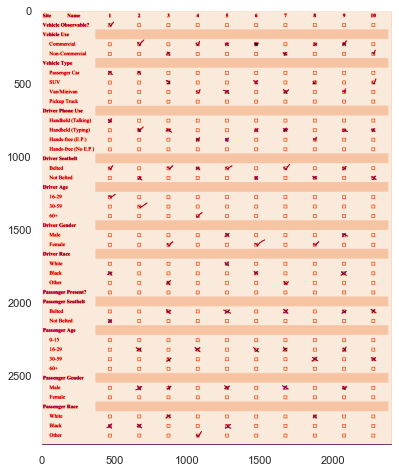

In [15]:
plt.figure(figsize=(13,8))
omr_extract.draw_img(image)
plt.grid()

Also, the following cell provides a view of the contours that I mentioned above. Those black areas are removed from the first image that we had.

In [16]:
cont_img = cv2.drawContours(omr_extract.bin_blk(images[0]), cont, -1, 255, -1)

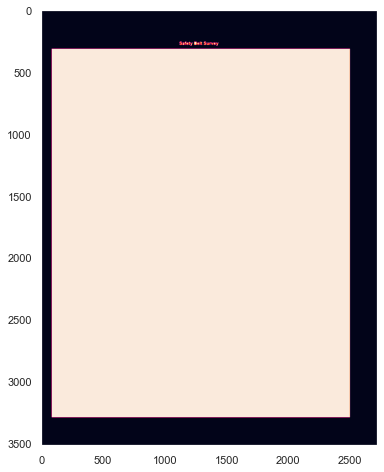

In [17]:
plt.figure(figsize=(13,8))
omr_extract.draw_img(cont_img)
plt.grid()

Now that we have the bird-eye view of the document and have removed the outer box, we again improve the contrast and move forward to identify the answer boxes.

In [18]:
image = cv2.addWeighted(image.copy(), 1.5, omr_extract.bin_wht(image), 0, 0)

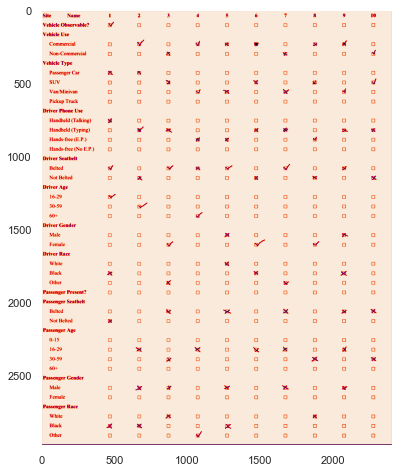

In [19]:
plt.figure(figsize=(13,8))
omr_extract.draw_img(image)
plt.grid()

Now for identifying the cells filled with answers, I am going to create a 2d array, named pandora, with the size equivalent to the number of answer boxes in the image. Then, the relative darkness of the answer boxes are going to be recorded in the mentioned pandora array, from which we can identify which answer boxes are filled. 
I have named it pandora because its the key for finding answers, and when it opens the results come out.

In [20]:
pandora = np.zeros((NUM_RW, NUM_CL), dtype=np.float32)

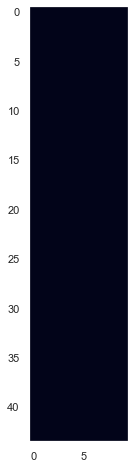

In [21]:
plt.figure(figsize=(13,8))
omr_extract.draw_img(pandora)
plt.grid()

In [22]:
for i in range(NUM_RW):
    for j in range(NUM_CL):
#record the relative darkness of answer boxes in pandora array
        x = np.sum(omr_extract.find_cellbox(image, i, j)) / (255 * STEPX * STEPY)
        pandora[i, j] = 1-x

The picture below shows the pandora array after the relative darkness of the cells have been recorded in it.

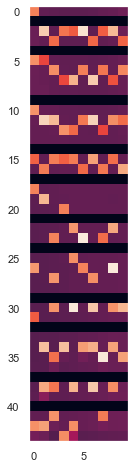

In [23]:
plt.figure(figsize=(13,8))
omr_extract.draw_img(pandora)
plt.grid()

According to the relative darkness above, the answer boxes that are filled are extracted and recorded below in a dictionary named answers. The keys of this dictionary are the question section names and the values of this dictionary are the actual  indexes of the boxes filled.

In [24]:
answers = omr_extract.answer_omr(pandora)

Present the results. The results are stored in numbers format. Explanation of recorded data in the `traffic.csv` file is mentioned below:
    
- __Vehicle Observablility__ : 0 = Not Observable, 1 = Observable
- __Vehicle Use__: 1 = Commercial, 2 = Non-Commercial
- __Vehicle Type__: 1 = Passenger Car, 2 = SUV, 3 = Van/Minivan, 4 = Pickup Truck
- __Driver Phone Use__: 1 = Handheld (Talking), 2 = Handheld (Typing), 3= Hands-free (E.P.), 4 = Hands-free (No E.P.)
- __Driver Seatbelt__: 0 = Unknown, 1 = Belted, 2 = Not Belted
- __Driver Age__: 0 = Unknown, 1 = 16-29, 2 = 30-59, 3 = Over 60 years old
- __Driver Gender__: 0 = Unknown, 1 = Male, 2 = Female
- __Driver Race__: 0 = Unknown, 1 = White, 2 = Black, 3 = Other
- __Passenger Presence__: 0 = No, 1 = Yes
- __Passenger Seatbelt__: 0 = Unknown, 1 = Belted, 2 = Not Belted
- __Passenger Age__: 0 = Unknown, 1 = 0-15, 2 = 16-29, 3 = 30-59, 4 = Over 60 years old
- __Passenger Gender__: 0 = Unknown, 1 = Male, 2 = Female
- __Passenger Race__: 0 = Unknown, 1 = White, 2 = Black, 3 = Other

In [25]:
answers

{'vehicle_observable': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'vehicle_use': [0, 1, 2, 1, 1, 1, 2, 1, 1, 2],
 'vehicle_type': [1, 1, 2, 3, 3, 2, 3, 2, 3, 2],
 'driver_phoneuse': [1, 2, 2, 3, 3, 2, 2, 3, 2, 2],
 'driver_seatbelt': [1, 2, 1, 1, 1, 2, 1, 2, 1, 2],
 'driver_age': [1, 2, 0, 3, 0, 0, 0, 0, 0, 0],
 'driver_gender': [0, 0, 2, 0, 1, 2, 0, 2, 1, 0],
 'driver_race': [2, 0, 3, 0, 1, 2, 3, 0, 2, 0],
 'passenger_present': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'passenger_seatbelt': [2, 0, 1, 0, 1, 0, 1, 0, 1, 1],
 'passenger_age': [0, 2, 3, 2, 0, 2, 2, 3, 2, 3],
 'passenger_gender': [0, 1, 1, 0, 1, 0, 1, 0, 1, 0],
 'passenger_race': [2, 2, 1, 3, 2, 0, 0, 1, 0, 0]}

Now, the extracted answers are exported to a pandas dataframe.

In [26]:
data=omr_extract.run_omr('images/one')[0]

In [27]:
data

Number  Vehicle Observable  Vehicle Use  Vehicle Type  Driver Phoneuse  \
0       1                   1            0             1                1   
1       2                   0            1             1                2   
2       3                   0            2             2                2   
3       4                   0            1             3                3   
4       5                   0            1             3                3   
5       6                   0            1             2                2   
6       7                   0            2             3                2   
7       8                   0            1             2                3   
8       9                   0            1             3                2   
9      10                   0            2             2                2   
0      11                   1            0             1                1   
1      12                   1            1             1                2   
2      13                   1            2             2                2   
3      14                   1            1             3                3   
4      15                   1            1             3                3   
5      16                   1            1             2                2   
6      17                   1            2             3                2   
7      18                   1            1             2                3   
8      19                   1            1             3                2   
9      20                   1            2             2                2   

   Driver Seatbelt  Driver Age  Driver Gender  Driver Race  Passenger Present  \
0                1           1              0            2                  0   
1                2           2              0            0                  0   
2                1           0              2            3                  0   
3                1           3              0            0                  0   
4                1           0              1            1                  0   
5                2           0              2            2                  0   
6                1           0              0            3                  0   
7                2           0              2            0                  0   
8                1           0              1            2                  0   
9                2           0              0            0                  0   
0                1           1              0            2                  0   
1                2           2              0            1                  0   
2                1           0              2            3                  0   
3                1           3              0            1                  0   
4                1           0              1            1                  0   
5                2           0              2            2                  0   
6                1           0              0            3                  0   
7                2           0              2            0                  1   
8                1           0              1            2                  0   
9                2           0              0            2                  0   

   Passenger Seatbelt  Passenger Age  Passenger Gender  Passenger Race  
0                   2              0                 0               2  
1                   0              2                 1               2  
2                   1              3                 1               1  
3                   0              2                 0               3  
4                   1              0                 1               2  
5                   0              2                 0               0  
6                   1              2                 1               0  
7                   0              3                 0               1  
8                   1     

Below, you may review the summary of the data. This survey form was filled just as a sample by me and the data is not representing real world results.

In [28]:
data.describe()

Number  Vehicle Observable  Vehicle Use  Vehicle Type  \
count  20.00000           20.000000    20.000000     20.000000   
mean   10.50000            0.550000     1.200000      2.200000   
std     5.91608            0.510418     0.615587      0.767772   
min     1.00000            0.000000     0.000000      1.000000   
25%     5.75000            0.000000     1.000000      2.000000   
50%    10.50000            1.000000     1.000000      2.000000   
75%    15.25000            1.000000     2.000000      3.000000   
max    20.00000            1.000000     2.000000      3.000000   

       Driver Phoneuse  Driver Seatbelt  Driver Age  Driver Gender  \
count        20.000000        20.000000   20.000000      20.000000   
mean          2.200000         1.400000    0.600000       0.800000   
std           0.615587         0.502625    1.046297       0.894427   
min           1.000000         1.000000    0.000000       0.000000   
25%           2.000000         1.000000    0.000000       0.000000   
50%           2.000000         1.000000    0.000000       0.500000   
75%           3.000000         2.000000    1.000000       2.000000   
max           3.000000         2.000000    3.000000       2.000000   

       Driver Race  Passenger Present  Passenger Seatbelt  Passenger Age  \
count    20.000000          20.000000           20.000000      20.000000   
mean      1.500000           0.050000            1.000000       2.050000   
std       1.100239           0.223607            0.648886       0.887041   
min       0.000000           0.000000            0.000000       0.000000   
25%       0.750000           0.000000            1.000000       2.000000   
50%       2.000000           0.000000            1.000000       2.000000   
75%       2.000000           0.000000            1.000000       3.000000   
max       3.000000           1.000000            2.000000       3.000000   

       Passenger Gender  Passenger Race  
count         20.000000       20.000000  
mean           0.900000        1.350000  
std            0.640723        0.933302  
min            0.000000        0.000000  
25%            0.750000        1.000000  
50%            1.000000        1.000000  
75%            1.000000        2.000000  
max            2.000000        3.000000

- Further plots can be generated using this data and modeling methods can be applied to identify the relationship between differenet variables in the data.